In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [3]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [4]:
# read data into dataframe  
path = 'ml_model_data/meters_for_ml.csv'
df = pd.read_csv(path, sep=",")
df

,meter_id,location,violation_description,fine_amount,counts,revenue,latitude,longitude,meter_type,policy_complexity,rate_type,park_limit
0,V77,101 VENICE WAY S,METER EXPIRED,63.0,465,29295.0,33.987418,-118.471119,Single-Space,11,FLAT,1.000000
1,V75,100 VENICE WAY,METER EXPIRED,63.0,450,28350.0,33.987243,-118.471043,Single-Space,11,FLAT,1.000000
2,NH940,4301 TUJUNGA AV,METER EXPIRED,63.0,447,28161.0,34.148960,-118.379082,Single-Space,13,FLAT,1.000000
3,NH935,4301 TUJUNGA AV,METER EXPIRED,63.0,446,28098.0,34.149560,-118.379083,Single-Space,13,FLAT,1.000000
4,V73,100 VENICE WAY,METER EXPIRED,63.0,430,27090.0,33.987264,-118.471196,Single-Space,11,FLAT,1.000000
5,NH934,4301 TUJUNGA AV,METER EXPIRED,63.0,427,26901.0,34.149693,-118.379082,Single-Space,13,FLAT,1.000000
6,V74,100 VENICE WAY,METER EXPIRED,63.0,420,26460.0,33.987256,-118.471134,Single-Space,11,FLAT,1.000000
7,V74,100 VENICE WAY,OUTSIDE LINES/METER,58.0,25,1450.0,33.987256,-118.471134,Single-Space,11,FLAT,1.000000
8,NH936,4301 TUJUNGA AV,METER EXPIRED,63.0,415,26145.0,34.149426,-118.379082,Single-Space,13,FLAT,1.000000
9,CB156,1300 HOPE ST S,METER EXPIRED,63.0,415,26145.0,34.037869,-118.266592,Single-Space,13,TOD,4.000000


In [5]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['latitude', 'longitude'])

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

/Users/pavelaltukhov/anaconda3/envs/meters_ml_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [6]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 33,421 points down to 17 clusters, for 99.9% compression in 7.75 seconds
Silhouette coefficient: -0.061


In [7]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [8]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [9]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'longitude':lons, 'latitude':lats})
rep_points.tail()

,longitude,latitude
12,-118.601962,34.201133
13,-118.262299,33.779432
14,-118.281449,33.784145
15,-118.517961,34.029236
16,-118.331583,34.005230


In [10]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['latitude']==row['latitude']) & (df['longitude']==row['longitude'])].iloc[0], axis=1)
rs.to_csv('ml_model_data/meters_gps_dbscan.csv', encoding='utf-8')
rs.tail()

,meter_id,location,violation_description,fine_amount,counts,revenue,latitude,longitude,meter_type,policy_complexity,rate_type,park_limit
12,CP46,21701 SHERMAN WY,METER EXPIRED,63.0,12,756.0,34.201133,-118.601962,Single-Space,13,FLAT,2.0
13,WN31,700 AVALON BL N,METER EXPIRED,63.0,13,819.0,33.779432,-118.262299,Single-Space,13,FLAT,2.0
14,WN355,1101 FIGUEROA PL,METER EXPIRED,63.0,11,693.0,33.784145,-118.281449,Single-Space,13,FLAT,2.0
15,P312,101 WEST CHANNEL RD,METER EXPIRED,63.0,13,819.0,34.029236,-118.517961,Single-Space,13,FLAT,1.0
16,LP275,4301 DEGNAN BL,METER EXPIRED,63.0,13,819.0,34.005230,-118.331583,Single-Space,13,FLAT,2.0


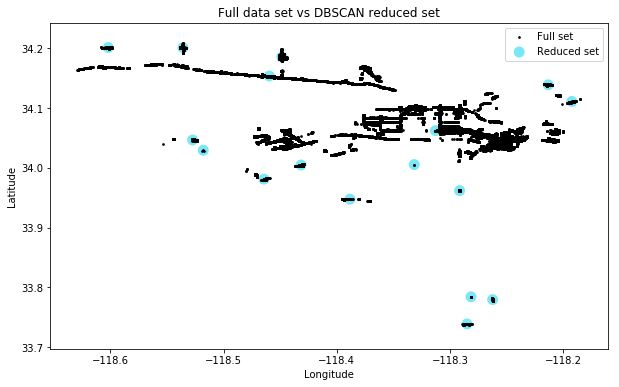

In [13]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#42ddf5', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()